In [1]:
import numpy as np
from numpy import sqrt
import matplotlib.pyplot as py
import getdist as gs
import os
import copy
from getdist import plots, loadMCSamples
from pathlib import Path
from functions import *

In [2]:
pathbase = "C:/Users/Jacob/Documents/Warwick Files/4y_project/Getdist/base_r/plikHM_TTTEEE_lowl_lowE"
dirs = os.listdir(pathbase)
root = "base_r_plikHM_TTTEEE_lowl_lowE"

samps = loadMCSamples(os.path.join(pathbase, root), settings={'ignore_rows':0.3})

C:/Users/Jacob/Documents/Warwick Files/4y_project/Getdist/base_r/plikHM_TTTEEE_lowl_lowE\base_r_plikHM_TTTEEE_lowl_lowE_1.txt
C:/Users/Jacob/Documents/Warwick Files/4y_project/Getdist/base_r/plikHM_TTTEEE_lowl_lowE\base_r_plikHM_TTTEEE_lowl_lowE_2.txt
C:/Users/Jacob/Documents/Warwick Files/4y_project/Getdist/base_r/plikHM_TTTEEE_lowl_lowE\base_r_plikHM_TTTEEE_lowl_lowE_3.txt
C:/Users/Jacob/Documents/Warwick Files/4y_project/Getdist/base_r/plikHM_TTTEEE_lowl_lowE\base_r_plikHM_TTTEEE_lowl_lowE_4.txt
Removed no burn in


numpy.ndarray

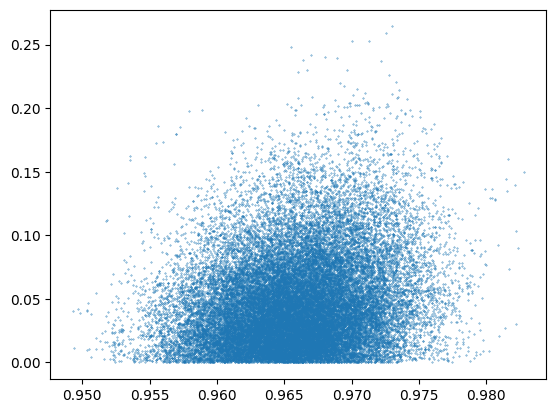

In [3]:
sampscopy = copy.deepcopy(samps)
params = samps.getParams()
py.scatter(params.ns, params.r, s = 0.1)
type(params.ns)

In [6]:
def tot_traj(Nstart, V_0, m, φ_0 = 15, dφ0 = 0.0001, boundmultiplier = 100, H0 = 2, suppress = False, epsilonstop = False):
    '''This function takes a solution from    trajectory()   , parametrises it by N, and integrates backwards (parametrising by N) to achieve
    a piece of the trajectory corresponding to earlier times'''
    T = int(φ_0/dφ0)
    gradpositive = True #to be explained
    φswap, Jswap, n0, epsilon = trajectory(V_0, m, φ_0, dφ0, boundmultiplier, H0, suppress)
    #
    #swap order of φ array and H array - we are about to integrate backwards in time
    φ1, J1 = φswap[::-1], Jswap[::-1]
    #
    #W start at the end of inflation, so we start at N = 0
    #Initialise arrays to bound the memory we will need
    N = np.zeros(boundmultiplier*T + 1)
    φ = np.zeros(boundmultiplier*T + 1)
    H = np.zeros(boundmultiplier*T + 1)
    ε = np.zeros(boundmultiplier*T + 1)
    #we have our φ values up to φ_0 and the corresponding H values already
    φ[:n0 + 1] = φ1
    H[:n0 + 1] = J1
    #assign epsilon at the start of the scheme, the end of inflation
    ε[0] = epsilon
    #Initialise number of steps n
    n = 0
    n_sgn_change = boundmultiplier*T + 1
    while (N[n] < Nstart) and (n < n0):
        #Here we are just reparametrising the H trjectory we already have
        dφ = φ[n+1] - φ[n]
        ε[n+1] = epsilon_calc(H[n+1], V_0, φ[n+1], m)
        #
        #we have what is effectively an RK2 scheme here - the error at each step of this loop is not intrinsically dependent
        #on the error of earlier steps, so there isn't as much reason to choose a high order integrator here as there is in
        #integrating the HJ equation
        #
        E1 = (2 / ε[n])**0.5
        E2 = (2 / ε[n+1])**0.5
        N[n+1] = N[n] + dφ*(E1 + E2)/4
        n += 1
    #
    #
    '''Next we make a series of checks:
    
    - (gradpositive = True) tells is that the standard scheme predicts sensible H', so we can continue as before
    
    -The (N < Nstart) check puts a time limit on the time span we consider; the scheme should stop at N = Nstart
    
    -A very large upper bound is chosen, linear in each of    boundmultiplier   and    φ_0
    
    -Inflation should not occur for ε > 1, so the default setting is that too large an ε will end the scheme, but by
    setting   (epsilonstop = False)   backwards integration will continue past this point'''
    #
    #
    while gradpositive and (N[n] < Nstart) and (n < boundmultiplier*T) and (ε[n] < 1 or not epsilonstop):
        while (N[n] < Nstart) and (n < boundmultiplier*T) and (ε[n] < 1 or not epsilonstop):
            #
            #The next check allows us to skip time-consuming checks if epsilon is clearly still not close to zero. In the unlikely case of
            #fatal errors, increasing the lower bound of the below epsilon check may help
            #
            if ε[n] > 0.001:
                dφ = min(0.5*(H[n] - ((V_0*(φ[n])**m)*(1/3))**0.5)/(grad_calc(H[n], V_0, φ[n], m)), dφ0)
                #RK4 section
                #
                K1 = grad_calc(H[n], V_0, φ[n], m)
                K2 = grad_calc(H[n] + 0.5*dφ*K1, V_0, φ[n] + 0.5*dφ, m)
                K3 = grad_calc(H[n] + 0.5*dφ*K2, V_0, φ[n] + 0.5*dφ, m)
                K4 = grad_calc(H[n] + dφ*K3, V_0, φ[n] + dφ, m)
                grad = (K1 + 2*K2 + 2*K3 + K4)/6
                H[n+1] = H[n] + dφ*grad
                φ[n+1] = φ[n] + dφ
                #
                ε[n+1] = epsilon_calc(H[n+1], V_0, φ[n+1], m)
                #
                #RK2 section
                #
                E1 = (2 / ε[n])**0.5
                E2 = (2 / ε[n+1])**0.5
                N[n+1] = N[n] + dφ*(E1 + E2)/4
                n += 1
            else:
               #At this stage, ε has become very small. We check at each stage whether we are going to pass φdot = 0, in which case we note this
                #and continue so that we may return to assume a change in sign
                coeff = f(H[n], V_0, φ[n], m)
                dφ = min(coeff*(H[n] - ((V_0*(φ[n])**m)*(1/3))**0.5)/(grad_calc(H[n], V_0, φ[n], m)), dφ0)
                #
                #We check whether the next gradient estimate corresponds to H' > 0. If so, we may proceed (and check the same for the other
                #gradient estimates), but as soon as a negative estimate is made we note this and will change the integrator
                if grad_sqr(H[n], V_0, φ[n], m) > 0:
                    K1 = grad_calc(H[n], V_0, φ[n], m)
                else:
                    gradpositive = False
                    break
                if grad_sqr(H[n] + 0.5*dφ*K1, V_0, φ[n] + 0.5*dφ, m):
                    K2 = grad_calc(H[n] + 0.5*dφ*K1, V_0, φ[n] + 0.5*dφ, m)
                else:
                    gradpositive = False
                    break
                if grad_sqr(H[n] + 0.5*dφ*K2, V_0, φ[n] + 0.5*dφ, m):
                    K3 = grad_calc(H[n] + 0.5*dφ*K2, V_0, φ[n] + 0.5*dφ, m)
                else:
                    gradpositive = False
                    break
                if grad_sqr(H[n] + dφ*K3, V_0, φ[n] + dφ, m):
                    K4 = grad_calc(H[n] + dφ*K3, V_0, φ[n] + dφ, m)
                else:
                    gradpositive = False
                    break
                grad = (K1 + 2*K2 + 2*K3 + K4)/6
                H[n+1] = H[n] + dφ*grad
                φ[n+1] = φ[n] + dφ
                ε[n+1] = epsilon_calc(H[n+1], V_0, φ[n+1], m)
                #SPACE
                J1 = (2 / ε[n])**0.5
                J2 = (2 / ε[n+1])**0.5
                N[n+1] = N[n] + dφ*(J1 + J2)/4
                n += 1
     #
    #once we note the unavoidable change in sign is imminent, we approximate φ constant, H' takes the negative of its last value,
    #so H is unchanged - see the associated dissertation for justification
    #
    if (N[n] < Nstart) and (n < boundmultiplier*T) and (ε[n] < 1 or not epsilonstop):
        H[n] = H[n-1]
        φ[n] = φ[n-1]
        ε[n] = ε[n - 1]
        #
        #Record the index when the sign of H' changes
        n_sgn_change = n
        #
        #Calculate the number of e-folds passed, as per the associated dissertation
        N[n] = N[n-1] + (4*grad_calc(H[n-1], V_0, φ[n-1], m)*((V_0*(φ[n-1])**m)**0.5))/((3**0.5)*((m*V_0*(φ[n-1])**(m-1))**0.5))
        #
        #In this final loop, we take the equivalent of dφ -> -dφ, H' takes negative square root
        #
    while (N[n] < Nstart) and (n < boundmultiplier*T) and (ε[n] < 1 or not epsilonstop):
        #step size
        dφ = min(0.5*(H[n] - ((V_0*(φ[n])**m)*(1/3))**0.5)/(grad_calc(H[n], V_0, φ[n], m)), dφ0)
        #
        #RK4
        #
        K1 = -grad_calc(H[n], V_0, φ[n], m)
        K2 = -grad_calc(H[n] + 0.5*dφ*K1, V_0, φ[n] + 0.5*dφ, m)
        K3 = -grad_calc(H[n] + 0.5*dφ*K2, V_0, φ[n] + 0.5*dφ, m)
        K4 = -grad_calc(H[n] + dφ*K3, V_0, φ[n] + dφ, m)
        grad = (K1 + 2*K2 + 2*K3 + K4)/6
        H[n+1] = H[n] - dφ*grad
        φ[n+1] = φ[n] - dφ
        #
        ε[n+1] = epsilon_calc(H[n+1], V_0, φ[n+1], m)
        #
        #RK2
        #
        E1 = (2 / ε[n])**0.5
        E2 = (2 / ε[n+1])**0.5
        N[n+1] = N[n] + dφ*(E1 + E2)/4
        #
        n += 1
    return TrajectoryResult(φ[:n+1], H[:n+1], n, ε[:n+1], N[:n+1], n_sgn_change)

φ1 = lambda n_s, r, m: 8*sqrt(2)*(r - 48)*m/(sqrt(r)*(n_s*r - 16 - r - 176)) #map gives φ values implied by likely r and n_s values
φdot1 = lambda n_s, r, m, V0: (V0**0.5)*sqrt((2*(48 - r)*((8*sqrt(2)*(48 - r)*m/(sqrt(r)*(176 + r + 16 - n_s*r)))**m)*r)/(48 - r))

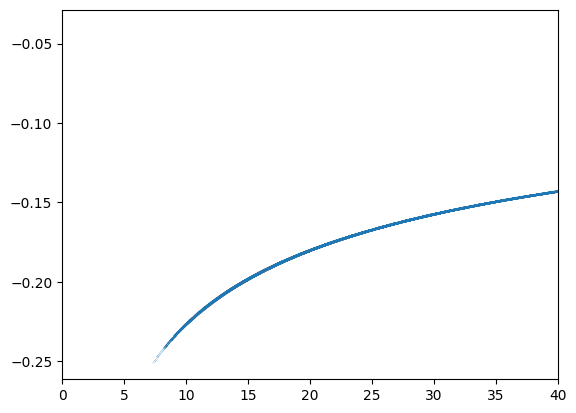

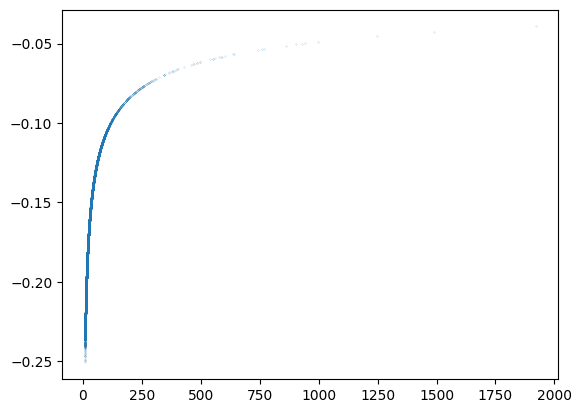

In [5]:
kchoice = 4/3
V0choice = 0.4
initφ = 15

φ1_scatter = [φ1(ns, r, 4/3) for [ns, r] in zip(params.ns, params.r)]
φdot1_scatter = [φdot1(ns, r, 4/3, V0choice) for [ns, r] in zip(params.ns, params.r)]
py.scatter(φ1_scatter, φdot1_scatter, s = 0.01)
py.xlim([0, 40])

trajectory_result = tot_traj(2, V0choice, kchoice, φ_0 = initφ)
py.plot(trajectory_result.N, trajectory_result.φ)

py.figure()
# py.scatter(φ1_scatter, φdot1_scatter, s = 0.01)

Now, we will evolve the data forwards and backwards in time to illustrate how the effective phase space evolves

In [9]:
kchoice = 4/3
V0choice = 0.4
initφ = 15

def data_ev(V_0, m, _N, dφ0 = 0.001, boundmultiplier = 10, suppress = False, epsilonstop = False, data = np.stack((params.ns, params.r)), NST = 60, pts_limit = 0):
    '''Takes data in form (n_s, r), converts to (ϕ, H) data corresponding to time NST, evolves to time _N, returns to (ϕ, ϕdot) form'''
    φ_ = [φ1(ns, r, m) for [ns, r] in data]
    #I shall use underscores do distinguish different starting φ from the list of starting φ_ for example
    φdot_ = [φdot1(ns, r, m, V_0) for [ns, r] in data]
    if float(NST) == float(_N):
        return np.stack((φ_, φdot_))
    else:
        newdot_ = np.zeros((2, len(φ_)))
        H_ = [sqrt(((v**2)/6) + V0choice*(φ**kchoice)/3) for [φ, v] in zip(φ_, φdot_)]
        DN = _N - NST
        if DN>0:
            sgn = 1
        else:
            sgn = -1
        for k, [φ_0, H0] in enumerate(zip(φ_, H_)):
            #The code takes a long time to run in its current form, so a limit on the number of points evolved has been written
            if pts_limit != 0:
                if pts_limit < k:
                    break
            T = int(φ_0/dφ0)
            gradpositive = True #to be explained
            N = np.zeros(boundmultiplier*T + 1)
            N[0] = NST
            φ = np.zeros(boundmultiplier*T + 1)
            H = np.zeros(boundmultiplier*T + 1)
            H[0] = H0
            φ[0] = φ_0
            ε = np.zeros(boundmultiplier*T + 1)
            ε[0] = epsilon_calc(H0, V_0, φ_0, m)
            #Initialise number of steps n
            n = 0
            n_sgn_change = boundmultiplier*T + 1
            while gradpositive:
                while gradpositive and (sgn*N[n] < sgn*_N) and (n < boundmultiplier*T) and (ε[n] < 1 or not epsilonstop):
                    #
                    #The next check allows us to skip time-consuming checks if epsilon is clearly still not close to zero. In the unlikely case of
                    #fatal errors, increasing the lower bound of the below epsilon check may help
                    #
                    if ε[n] > 0.001:
                        dφ = sgn*min(0.5*(H[n] - ((V_0*(φ[n])**m)*(1/3))**0.5)/(grad_calc(H[n], V_0, φ[n], m)), dφ0)
                        #RK4 section
                        #
                        K1 = grad_calc(H[n], V_0, φ[n], m)
                        K2 = grad_calc(H[n] + 0.5*dφ*K1, V_0, φ[n] + 0.5*dφ, m)
                        K3 = grad_calc(H[n] + 0.5*dφ*K2, V_0, φ[n] + 0.5*dφ, m)
                        K4 = grad_calc(H[n] + dφ*K3, V_0, φ[n] + dφ, m)
                        grad = (K1 + 2*K2 + 2*K3 + K4)/6
                        H[n+1] = H[n] + dφ*grad
                        φ[n+1] = φ[n] + dφ
                        #
                        ε[n+1] = epsilon_calc(H[n+1], V_0, φ[n+1], m)
                        #
                        #RK2 section
                        #
                        E1 = (2 / ε[n])**0.5
                        E2 = (2 / ε[n+1])**0.5
                        N[n+1] = N[n] + dφ*(E1 + E2)/4
                        n += 1
                    else:
                       #At this stage, ε has become very small. We check at each stage whether we are going to pass φdot = 0, in which case we note this
                        #and continue so that we may return to assume a change in sign
                        coeff = f(H[n], V_0, φ[n], m)
                        dφ = sgn*min(coeff*(H[n] - ((V_0*(φ[n])**m)*(1/3))**0.5)/(grad_calc(H[n], V_0, φ[n], m)), dφ0)
                        #
                        #We check whether the next gradient estimate corresponds to H' > 0. If so, we may proceed (and check the same for the other
                        #gradient estimates), but as soon as a negative estimate is made we note this and will change the integrator
                        if grad_sqr(H[n], V_0, φ[n], m) > 0:
                            K1 = grad_calc(H[n], V_0, φ[n], m)
                        else:
                            gradpositive = False
                            break
                        if grad_sqr(H[n] + 0.5*dφ*K1, V_0, φ[n] + 0.5*dφ, m):
                            K2 = grad_calc(H[n] + 0.5*dφ*K1, V_0, φ[n] + 0.5*dφ, m)
                        else:
                            gradpositive = False
                            break
                        if grad_sqr(H[n] + 0.5*dφ*K2, V_0, φ[n] + 0.5*dφ, m):
                            K3 = grad_calc(H[n] + 0.5*dφ*K2, V_0, φ[n] + 0.5*dφ, m)
                        else:
                            gradpositive = False
                            break
                        if grad_sqr(H[n] + dφ*K3, V_0, φ[n] + dφ, m):
                            K4 = grad_calc(H[n] + dφ*K3, V_0, φ[n] + dφ, m)
                        else:
                            gradpositive = False
                            break
                        grad = (K1 + 2*K2 + 2*K3 + K4)/6
                        H[n+1] = H[n] + dφ*grad
                        φ[n+1] = φ[n] + dφ
                        ε[n+1] = epsilon_calc(H[n+1], V_0, φ[n+1], m)
                        #SPACE
                        J1 = (2 / ε[n])**0.5
                        J2 = (2 / ε[n+1])**0.5
                        N[n+1] = N[n] + dφ*(J1 + J2)/4
                        n += 1
             #
            #once we note the unavoidable change in sign is imminent, we approximate φ constant, H' takes the negative of its last value,
            #so H is unchanged - see the associated dissertation for justification
            #
            
            if (sgn*N[n] < sgn*_N) and (n < boundmultiplier*T) and (ε[n] < 1 or not epsilonstop):
                H[n] = H[n-1]
                φ[n] = φ[n-1]
                ε[n] = ε[n - 1]
                #
                #Record the index when the sign of H' changes
                n_sgn_change = n
                #
                #Calculate the number of e-folds passed, as per the associated dissertation
                N[n] = N[n-1] + (4*grad_calc(H[n-1], V_0, φ[n-1], m)*((V_0*(φ[n-1])**m)**0.5))/((3**0.5)*((m*V_0*(φ[n-1])**(m-1))**0.5))
                #
                #In this final loop, we take the equivalent of dφ -> -dφ, H' takes negative square root
                #
            while (sgn*N[n] < sgn*_N) and (n < boundmultiplier*T) and (ε[n] < 1 or not epsilonstop):
                #step size
                dφ = sgn*min(0.5*(H[n] - ((V_0*(φ[n])**m)*(1/3))**0.5)/(grad_calc(H[n], V_0, φ[n], m)), dφ0)
                #
                #RK4
                #
                K1 = -grad_calc(H[n], V_0, φ[n], m)
                K2 = -grad_calc(H[n] + 0.5*dφ*K1, V_0, φ[n] + 0.5*dφ, m)
                K3 = -grad_calc(H[n] + 0.5*dφ*K2, V_0, φ[n] + 0.5*dφ, m)
                K4 = -grad_calc(H[n] + dφ*K3, V_0, φ[n] + dφ, m)
                grad = (K1 + 2*K2 + 2*K3 + K4)/6
                H[n+1] = H[n] - dφ*grad
                φ[n+1] = φ[n] - dφ
                #
                ε[n+1] = epsilon_calc(H[n+1], V_0, φ[n+1], m)
                #
                #RK2
                #
                E1 = (2 / ε[n])**0.5
                E2 = (2 / ε[n+1])**0.5
                N[n+1] = N[n] + dφ*(E1 + E2)/4
                #
                n += 1
            newdot = -1*sqrt(6*H[n] - V_0*2*(φ[n]**m))
            newdot_[:, k] = np.array([φ[n], newdot])
        return newdot_

            
            
    
    
    

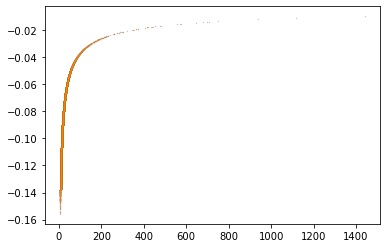

In [10]:
#Tests
data_ev_testres = data_ev(V0choice, 1, 60) #Should return the data in phi, phidot form
py.scatter(data_ev_testres[0, :], data_ev_testres[1, :], s = 0.01)
phi1_scatter = [phi1(ns, r, 1) for [ns, r] in zip(params.ns, params.r)]
phidot1_scatter = [phidot1(ns, r, 1, V0choice) for [ns, r] in zip(params.ns, params.r)]
py.scatter(phi1_scatter, phidot1_scatter, s=0.01)

In [11]:
data_ev_testres = data_ev(V0choice, 1, 60.1, pts_limit = 10)
print(data_ev_testres[:, 0:3])

KeyboardInterrupt: 

In [35]:
data_ev(V0choice, 1, 60.1, pts_limit = 1)

KeyboardInterrupt: 

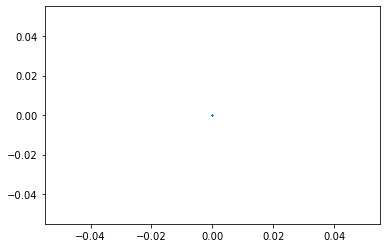

In [25]:
py.scatter(data_ev_testres[0,:], data_ev_testres[1,:], s=0.1)

In [ ]:
data_ev_testres

In [7]:
test_v = np.zeros((2,3))
test_v[:, 1] = np.array([1.0, 2.0])
test_v

array([[0., 1., 0.],
       [0., 2., 0.]])

In [11]:
for i, j in enumerate(zip([1,2,3,4,5], [10, 11, 12, 13, 14])):
    print(i ,j)

0 (1, 10)
1 (2, 11)
2 (3, 12)
3 (4, 13)
4 (5, 14)
